In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.stats import linregress
from scipy import stats
from scipy.special import erfinv, erf

In [2]:
%ls data/recall_scores/panic_fine44_*

data/recall_scores/panic_fine44_a1.pkl
data/recall_scores/panic_fine44_a2.pkl
data/recall_scores/panic_fine44_a3.pkl
data/recall_scores/panic_fine44_prompt0_gpt-4-0613_set1.pkl


### Human scores 

human scores are stored in separate files each file represent a pandas data series, each entry consisted of list of recalled clauses.

In [3]:
# reading human evaluation of the recalls
human_scores = {}
for k in range(1,4):
      human_scores[k]= pd.read_pickle( f'data/recall_scores/panic_fine44_a{k}.pkl')
#reading evaluated story segmentation
panic_segmentation=pd.read_pickle('data/recall_scores/panic_segmentation.pkl')['fine44']
# reading GPT-4 scores
gpt_scores = pd.read_pickle("data/recall_scores/panic_fine44_prompt0_gpt-4-0613_set1.pkl")

# Recall Analysis


For recall, we construct a hit matrix. Let us denote this by $h^{\mu}_{i}$. We have that

$h_{i}^{\mu} = 1$ if subject $\mu$ recalled clause $i$. Otherwise, $h_{i}^{\mu} = 0$. From this matrix, we can construct

- Recall Probability
\begin{equation}
r_{i} = \frac{1}{N}\sum_{\mu = 1}^{N} h_{i}^{\mu}
\end{equation}

- Total Items Recalled
 \begin{equation}
 \langle R \rangle = \sum_{i} r_{i} = \frac{1}{N} \sum_{\mu} R^{\mu} = \frac{1}{N} \sum_{i, \mu} h_{i}^{\mu}
 \end{equation}

where $R^{\mu} = \sum_{i =1}^{L} h_{i}^{\mu}$


- Variance of Recall

The second moment is
\begin{equation}
m_{2,R} = \frac{1}{N} \sum_{\mu} \left(R^{\mu}\right)^{2} = \frac{1}{N} \sum_{\mu} \sum_{i, i'} h_{i}^{\mu} h_{i'}^{\mu}
\end{equation}

The variance is

\begin{align}
v_{R} = m_{2,R} - m_{1,R}^{2}
\end{align}

In [4]:
# This function computes the hit matrix
def get_hit_matrix(scores, segmentation):
    Ss = len(scores)
    total_seg_long = len(segmentation.split('\n'))
    hit_matrix = np.zeros((Ss,total_seg_long))
    for k,r in enumerate(scores):
        if r!=[]:
            hit_matrix[k,np.array(r)-1] = 1
    return hit_matrix


In [5]:
panic_segmentation_split= panic_segmentation.split('\n')
total_seg = len(panic_segmentation_split)
seg_length = total_seg #len(segmentation.split('\n'))

human_hit= {}
for k in range(1,4):
    human_hit[k] = get_hit_matrix(human_scores[k],panic_segmentation)

human_data = np.vstack([h.mean(axis=0) for h in human_hit.values()])

human_hit_mean = np.mean(human_data,axis=0)
human_hit_std= np.std(human_data,axis=0)
human_hit_min = np.min(human_data,axis = 0)
human_hit_max = np.max(human_data,axis = 0)

gpt_hit_1 = get_hit_matrix(gpt_scores,panic_segmentation) 

# Reliability of GPT-4 scoring recall (Figure 1)
 
Here we compare evaluation of recalls by humans and by GPT-4

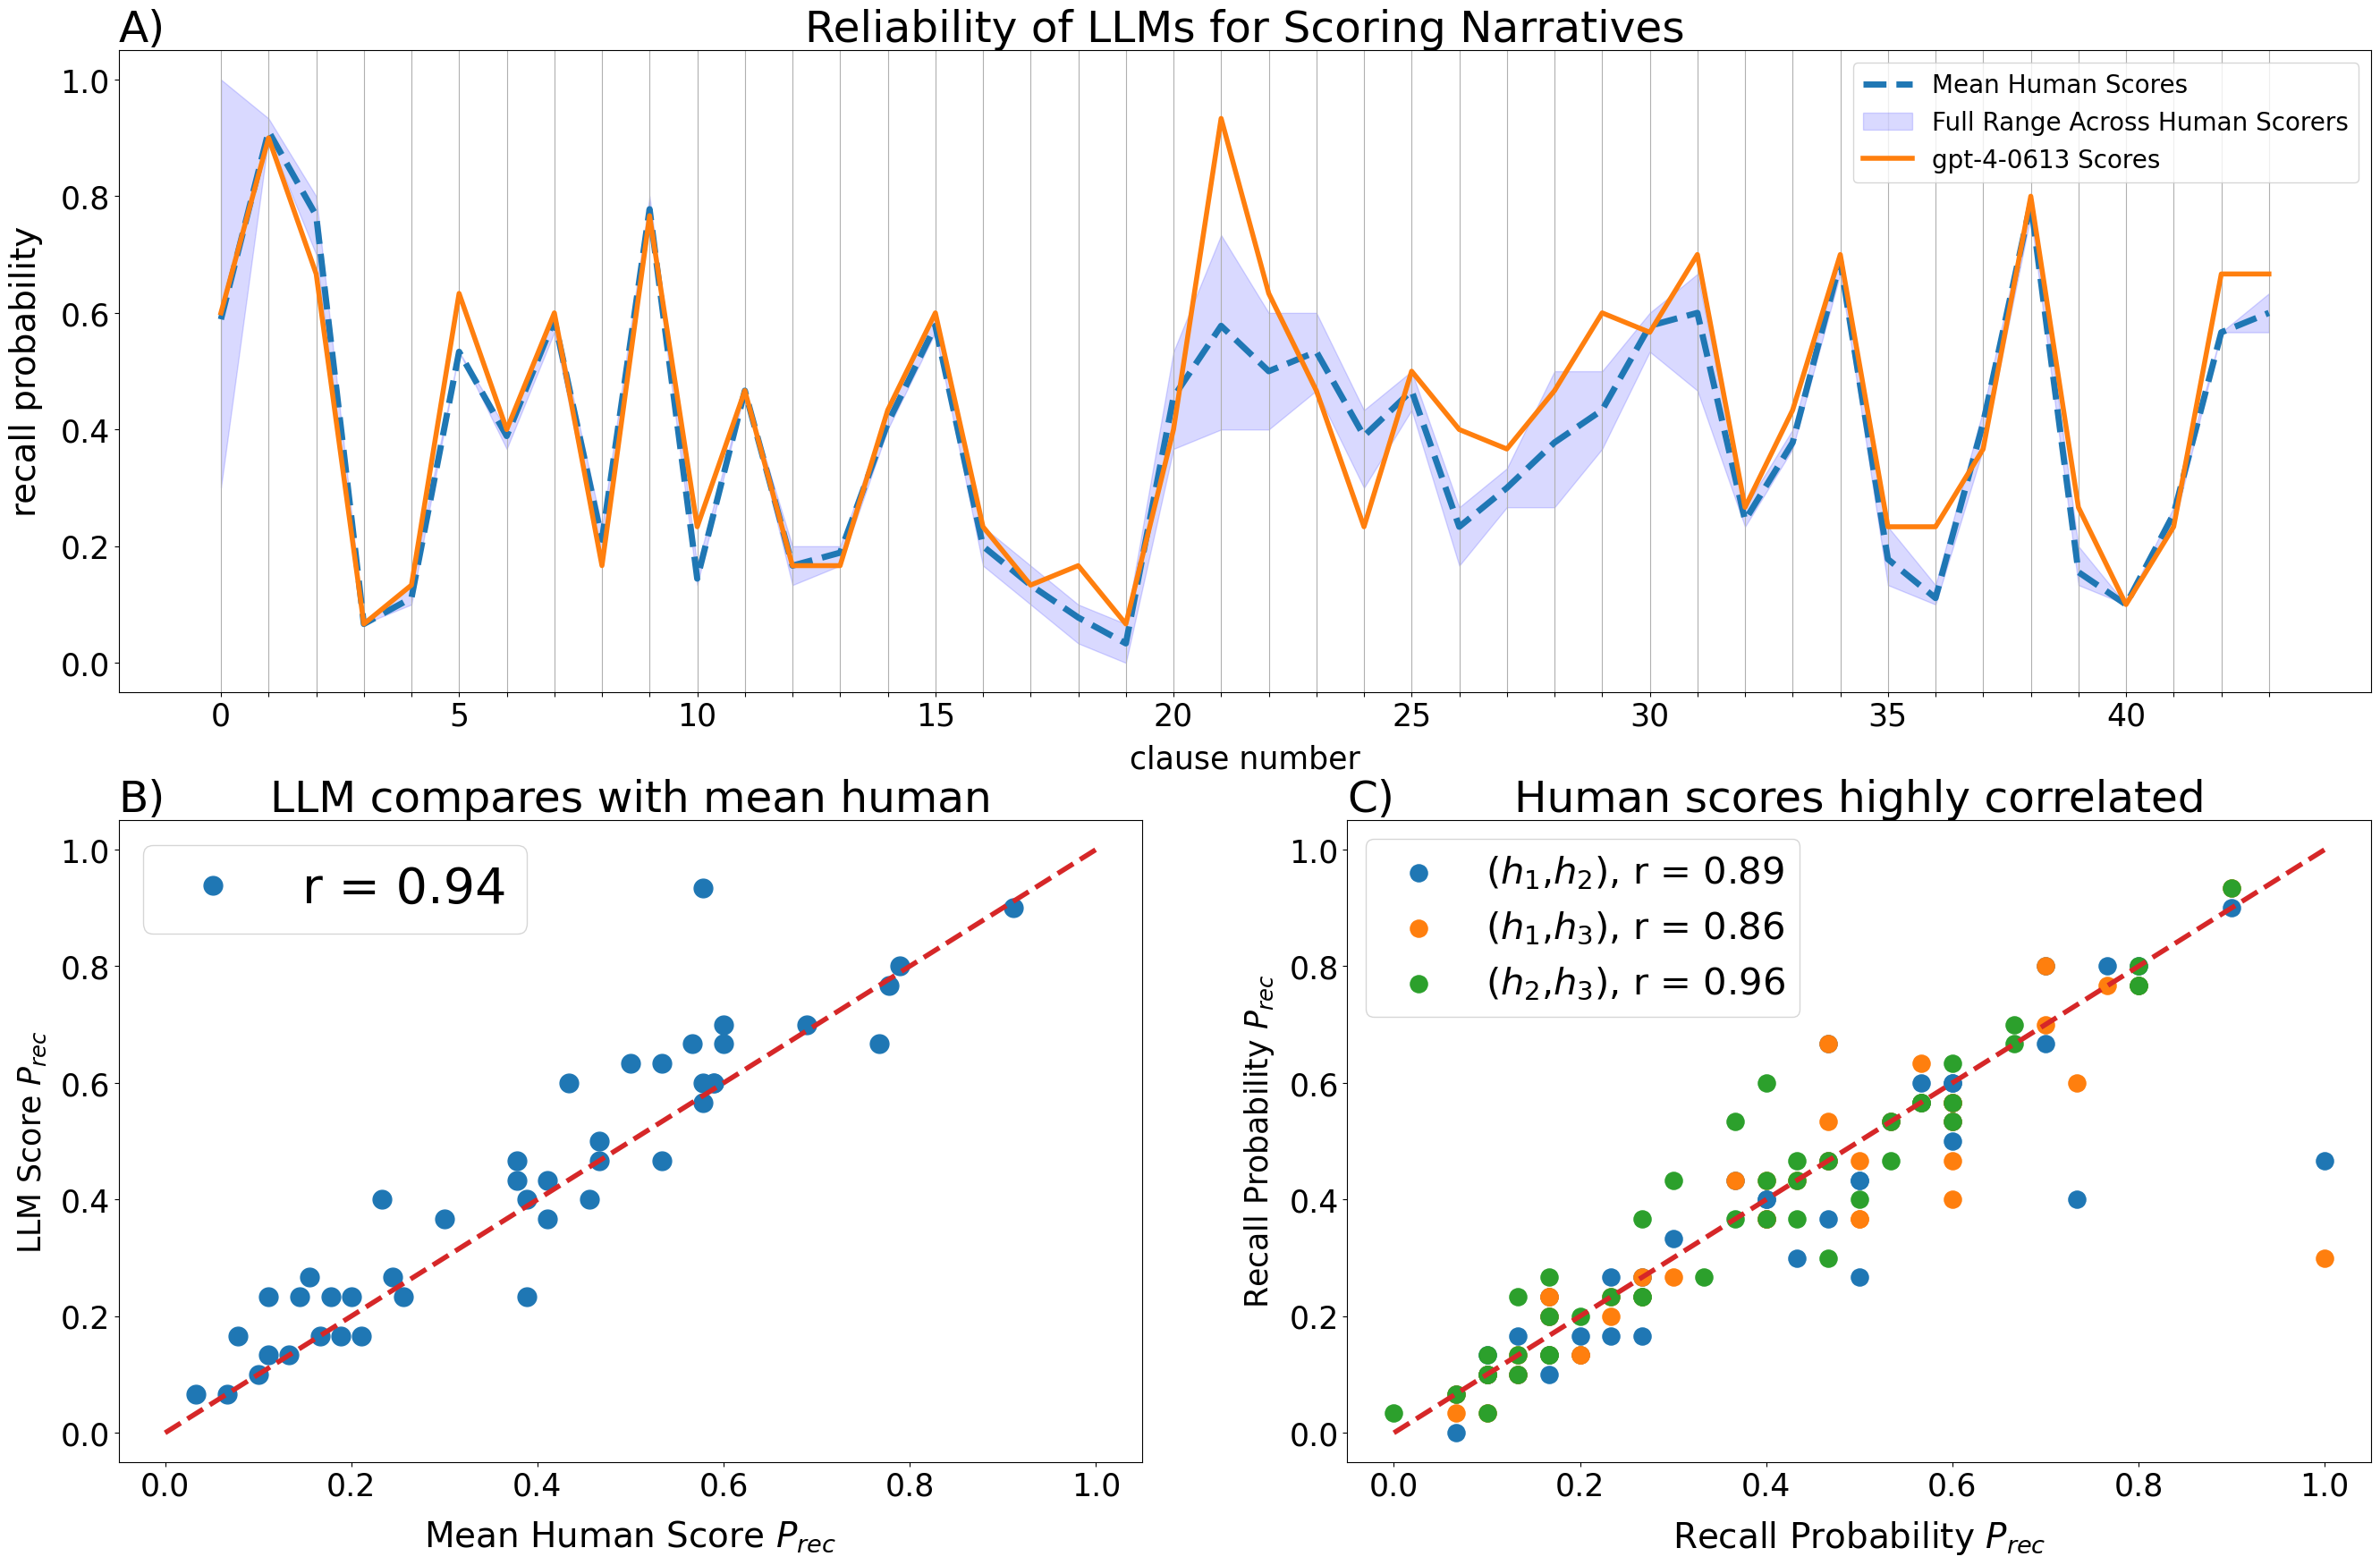

In [12]:
fig = plt.figure(figsize=(32.5, 20.5))  #, layout="constrained"
spec = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(spec[0, :])

ax = plt.gca()
ax0.set_xticks(np.arange(seg_length))


temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::5]))
for label in temp:
    label.set_visible(False)


#ax.set_xticks(2*np.arange(1,int((seg_length+1)/2)))
#ax.set_xticklabels(2*np.arange(1,int((seg_length+1)/2)))
#ax.set_xticklabels(np.arange(1,seg_length+1)) # range of values in edges

#ax0.set_xticks(fontsize=14)
#ax0.set_yticks(fontsize=14)

ax0.tick_params(axis='both', which='major', labelsize=25)

ax0.plot(np.arange(1,seg_length+1)-1,human_hit_mean,'--',linewidth = 5,label = 'Mean Human Scores',color='tab:blue')
ax0.fill_between(np.arange(1,seg_length+1)-1,human_hit_min, human_hit_max, color='b', alpha=.15,label = 'Full Range Across Human Scorers')

ax0.plot(np.arange(1,seg_length+1)-1,gpt_hit_1.mean(axis=0),'-',markersize = 12,linewidth = 4,label='gpt-4-0613 Scores',color='tab:orange')


ax0.set_ylabel('recall probability',labelpad = 14,fontsize = 28)
ax0.set_xlabel('clause number', labelpad = 10,fontsize = 25)

ax0.xaxis.grid(True)
#plt.savefig('reliability_plot.png')
ax0.legend(fontsize= 20)



ax10 = fig.add_subplot(spec[1, 0])
#annotate_axes(ax10, 'ax10')
rval = np.round(np.corrcoef(gpt_hit_1.mean(axis = 0),human_hit_mean.T)[0,1],2)
ax10.plot(human_hit_mean,gpt_hit_1.mean(axis = 0),'o',markersize = 15,label = 'r = '+str(rval))
#ax10.scatter(human_hit_mean,gpt_hit_chat.mean(axis = 0),s = 70,label = 'r = '+str(rval))
#ax10.scatter(human_hit_mean,gpt_hit_3.mean(axis = 0),s = 70,label = 'r = '+str(rval))
ax10.plot([0,1],[0,1],'--' ,linewidth = 4,color = 'tab:red')
ax10.tick_params(axis='both', which='major', labelsize=25)
ax10.set_xlabel('Mean Human Score $P_{rec}$',labelpad = 14,fontsize = 28)
ax10.set_ylabel('LLM Score $P_{rec}$', labelpad = 10,fontsize = 25)

ax10.legend(fontsize = 40)


r_human = np.corrcoef(human_data)

rval01 = np.round(r_human[0,1],2)
rval02 = np.round(r_human[0,2],2)
rval12 = np.round(r_human[1,2],2)
ax11 = fig.add_subplot(spec[1, 1])

#ax11.scatter(gpt_hit_1.mean(axis = 0),gpt_hit_3.mean(axis = 0),s = 190,label = 'r = '+str(rval))

ax11.scatter(human_data[0],human_data[1],s = 190,label = '($h_{1}$,$h_{2}$), r = '+str(rval01))
ax11.scatter(human_data[0],human_data[2],s = 190,label = '($h_{1}$,$h_{3}$), r = '+str(rval02))
ax11.scatter(human_data[1],human_data[2],s = 190,label = '($h_{2}$,$h_{3}$), r = '+str(rval12))
#ax10.scatter(human_hit_mean,gpt_hit_3.mean(axis = 0),s = 70,label = 'r = '+str(rval))
ax11.plot([0,1],[0,1],'--' ,linewidth = 4,color = 'tab:red')


ax11.tick_params(axis='both', which='major', labelsize=25)
ax11.set_xlabel('Recall Probability $P_{rec}$',labelpad = 14,fontsize = 28)

ax11.set_ylabel('Recall Probability $P_{rec}$', labelpad = 10,fontsize = 25)


ax0.set_title('A)', loc = 'left',fontsize = 35)
ax10.set_title('B)', loc = 'left',fontsize = 35)
ax11.set_title('C)', loc = 'left',fontsize = 35)

ax11.legend(fontsize = 30)
#annotate_axes(ax11, 'ax11')

ax0.set_title('Reliability of LLMs for Scoring Narratives',fontsize = 35)
ax10.set_title('LLM compares with mean human',fontsize = 35)
ax11.set_title('Human scores highly correlated',fontsize = 35)

plt.savefig('figure-reliability.svg',bbox_inches = 'tight')
plt.show()



# Scaling law in narrative recall (Figure 2)

# Recognition Analysis

Below are two functions which are used to compute the mean $\langle M\rangle$ and the variance via bootstrap. First, to set up notation, the recognition data for each participant is ${\bf x}^{\mu}(t) \in \{-1,0,1\}^{2L}$, where the $2L$ vector encodes the outcome of the recognition experiment for trial $t$, in the following way. 

For a given story with $L$ clauses, the pool of subjects is exposed to $L$ lures. We index the clauses $i = 1, ..., L$, and the lures $i = L+1, ..., 2L$. In a given trial, we denote the sequence of clauses/lures as $i_{t}$ for $t = 1, ...,S$. 

The outcome of a trial will take one of the following values:

- $o^{+}$: true positive, or equivalently 'hit'
-  $o^{-}$: true negative, or a 'miss'
- $l^{+}$: false positive, or a 'false alarm'
- $l^{-}$: false negative, or a 'correct rejection'

We can encode this in our vector encoding of the outcome in the following way. Let $o^{+} = l^{+}  =  1$ and $o^{-}= l^{-}  =  -1$. Then let $X^{\mu}(t)$ encode this value for each outcome. In other words, $X^{\mu}(t)$ only records whether the subjects says 'Yes' or 'No'. Then


$x_{i}^{\mu}(t) = \delta_{i i_{t}} X^{\mu}(t)$


"recog_hit_matrix" computes precisely this third-order tensor $x_{i}^{\mu}(t)$. 



From this representation, we can extract some useful quantities. 


 - pTPR (Population True Positive Rate): We obtain this from the formula (note the summation over $i$ is restricted to values $\le L$)
 \begin{equation}
 pTPR(L) = \frac{1}{2} \frac{\sum_{\mu,t} \sum_{i = 1}^{L} \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu, t}\sum_{i=1}^{L} | x_{i}^{\mu}(t)|}
 \end{equation}

The reason is that $\sum_{\mu, t} \sum_{i = 1}^{L} x_{i}^{\mu}(t) = H - M$, where $H$ is the total hits and $M$ is the total misses. Whereas $\sum_{\mu, t} \sum_{i = 1}^{L} |x_{i}^{\mu}(t)| = H + M$. This quantity is therefore equivalent to $H/(H+M)$. 

 - pFPR (Population False Positive Rate): We obtain this from the formula
 \begin{equation}
 pFPR(L) = \frac{1}{2} \frac{\sum_{\mu, t} \sum_{i = L+1}^{2L} \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu, t}\sum_{i=L+1}^{2L} | x_{i}^{\mu}(t)|}
 \end{equation}

Notice that the only difference here is the summation of $i$ goes from $L+1$ to $2L$. This quantity therefore is equavalent to $FA/(FA + CR)$

- Recognition Probability 
\begin{align}
 m_{i} = \frac{1}{2} \frac{\sum_{\mu, t}  \left( x_{i}^{\mu}(t) + | x_{i}^{\mu}(t)| \right)}{\sum_{\mu, t} | x_{i}^{\mu}(t)|}
\end{align}

This is computed by keeping the clause fixed, and computing the $H_{i}/(H_{i} + M_{i})$ for a given clause $i$. 


The estimate for the total number of clauses encoded is given by the formula

\begin{align}
\langle M \rangle = L \frac{\Big(pTPR - pFPR \Big)}{1 - pFPR}
\end{align}



{\bf Proof of formula for M}:


We calculate the probability of of a hit:


\begin{align}
P(hit) = P(yes|m \in M)P(m \in M) + P(yes| m \notin M) P(m \notin M)\\
P(hit) = M/L + P(fa) (1 - M/L) = P(fa) + (1- P(fa)) M/L
\end{align}
So that

\begin{align}
 M = \frac{L}{1-P(fa)} \left( P(hit) - P(fa)\right)
\end{align}




In [26]:
# this function lists all the files in the dataset folder

def files_in_folder(folder, ext):
    files_datasets = []
    for fname in os.listdir(os.path.join('data/', folder)):
        if not fname.endswith(ext):
            continue
        yield fname

#This function constructs the basic third-order tensor which encapsulates the recognition data

def recog_hit_matrix(dataset):
    segmentation = dataset['segmentation']
    seg_list = segmentation.split('\n')
    lure_list = list(dataset['lures'].values)
    clause_pool = seg_list + lure_list
    L = len(seg_list)
    recog_data = dataset['recognition']
    pop = len(recog_data)
    T = len(recog_data[0])
    id_len = len(clause_pool)
    recog_arr = np.zeros((pop,id_len,T))

    recog_data_num = []

    for p in range(pop):
        T = len(recog_data[p])
        r_p = []
        for t in range(T):
            rdvec = recog_data[p][t]
            outcome = rdvec['value'] 
            idx = rdvec['id']
            if idx < id_len:
                if outcome == 'hit' or outcome == 'fa':
                    bin_outcome = 1.;
                    r_p +=[[idx,1]];
                else:
                    bin_outcome = -1.;
                    r_p +=[[idx,0]]

                recog_arr[p,idx,t] = bin_outcome
    
    return recog_arr


#############################################
# These are very similar functions, just with different arguments


#This funcion depends on T, and does not 
def recog_prob(recog_arr,T):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:T].sum(axis = 2).sum(axis = 0)    # Sum over Trial and Population
    tot = abs(recog_arr[:,:L,:T]).sum(axis = 2).sum(axis = 0)
    
    dh_lure = recog_arr[:,L:,:T].sum(axis = 2).sum(axis = 0)
    tot_lure = abs(recog_arr[:,L:,:T]).sum(axis = 2).sum(axis = 0)
    
    return  .5*(dh + tot)/tot, .5*(dh_lure + tot_lure)/tot_lure

def recog_prob_dist(dataset):     #takes only dataset as input
    r_mat = recog_hit_matrix(dataset)
    T = r_mat.shape[2]
    hr, far = recog_prob(r_mat,T)
    
    #L = int(r_mat.shape[1]/2)
    #rdiff = r_mat[:,:L,:].sum(axis=2).sum(axis=0)     #sum over ALL trials and Population
    #rsum = abs(r_mat[:,:L,:]).sum(axis=2).sum(axis=0)
    #r_prob = .5*(rdiff+rsum)/rsum
    return hr,far






#############################################

#This leaves T, total number of trials, an adjustable argument to compute the population averaged M

def mean_recog(recog_arr,T):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:T].sum()
    tot = abs(recog_arr[:,:L,:T]).sum()
    tpr = .5*(dh + tot)/tot
    
    dh_lure = recog_arr[:,L:,:T].sum()
    tot_lure = abs(recog_arr[:,L:,:T]).sum()
    far = .5*(dh_lure + tot_lure)/tot_lure
    
    
    
    return  L*(tpr + far)/(1 - far) #L*(1 - 2*(1 - tpr))
    

    
def tpr_time(recog_arr):
    L = int(recog_arr.shape[1]/2)
    dh = recog_arr[:,:L,:].sum(axis=0).sum(axis = 0)
    tot = abs(recog_arr[:,:L,:]).sum(axis=0).sum(axis = 0)
    tpr = .5*(dh + tot)/tot
    
    
    return  L, tpr




        #This computes the mean and standard deviation of the population vector
def R_stats(dataset):
    recall_data = dataset['recall scores']
    segmentation = dataset['segmentation'] 
    recall_hits = get_hit_matrix(recall_data,segmentation)
    R_pop = recall_hits.sum(axis = 1)
    #N_pop = recall_hits.shape[0]
    #R_mean = recall_hits.sum()/N_pop
    #R_var = np.matmul(recall_hits.T,recall_hits).sum()/N_pop - R_mean**2
    return R_pop.mean(), R_pop.std()


def M_probs(dataset,sample_frac):
    r_mat = recog_hit_matrix(dataset)
    P,LL,T = r_mat.shape       #P = population, LL = 2*story_length, T = trials
    L = int(LL/2)
    r_mat = r_mat.swapaxes(0,1)
    r_mat = r_mat.reshape(LL,P*T)
    sample = int(sample_frac*P*T)
    subset = np.random.choice(range(P*T),sample)   #use to be random.sample
    subset2 = np.random.choice(range(P*T),sample)
    
    r_boot_old = r_mat[:L,subset]
    r_boot_new = r_mat[L:,subset2]
    
    rdiff_old = r_boot_old.sum();
    
    rdiff_new = r_boot_new.sum()
    
    
    rsum_old = abs(r_boot_old).sum()
    hits= .5*(rdiff_old + rsum_old)
    hit_miss = rsum_old
    TPR = hits/hit_miss
    
    rsum_new = abs(r_boot_new).sum()
    fa= .5*(rdiff_new + rsum_new)
    fa_cr = rsum_new
    FAR = fa/fa_cr
    
    return TPR, FAR

#Compute M from the population

def M_sample(dataset,sample_frac):
    r_mat = recog_hit_matrix(dataset)
    P,LL,T = r_mat.shape       #P = population, LL = 2*story_length, T = trials
    L = int(LL/2)
    r_mat = r_mat.swapaxes(0,1)
    r_mat = r_mat.reshape(LL,P*T)
    sample = int(sample_frac*P*T)
    subset = np.random.choice(range(P*T),sample)
    subset2 = np.random.choice(range(P*T),sample)
    
    r_boot_old = r_mat[:L,subset]
    r_boot_new = r_mat[L:,subset2]
    
    rdiff_old = r_boot_old.sum();
    
    rdiff_new = r_boot_new.sum()
    
    
    rsum_old = abs(r_boot_old).sum()
    hits= .5*(rdiff_old + rsum_old)
    hit_miss = rsum_old
    TPR = hits/hit_miss
    
    rsum_new = abs(r_boot_new).sum()
    fa= .5*(rdiff_new + rsum_new)
    fa_cr = rsum_new
    FAR = fa/fa_cr
    
    return L*(TPR - FAR)/(1 - FAR)



# collect many bootstrap samples
def M_stats(dataset,sample_frac,samples):
    m_samp = []
    for i in range(samples):
        m_samp += [M_sample(dataset,sample_frac)]
    
    return np.array(m_samp)


In [28]:
# Set bootstrap parameters for estimating errors of M
sample_frac = 1.;   #sets fraction of dataset to sample from, used 0.2 before
samples = 2000;  #how many samples to collect for bootstrap, used 500 before

Rm = []
R_err = []
Mm = []
M_err = []
Lx = []

story_name = []

tpr_x = []
far_x = []

for f in files_in_folder('compiled_data', '.pkl'):
    if f not in ['ghosts.pkl']:        #f!='ghosts' and f!='hester_v2-church-scrambled':
        print('     ', f)
        fn = 'data/compiled_data/' + f
        dataset = pd.read_pickle(fn)
        Lx +=[len(dataset['segmentation'].split('\n'))]
        
        r_mean,r_std = R_stats(dataset)
        
        mt_pop = M_stats(dataset,sample_frac,samples)
        
        tpr, far = M_probs(dataset,1.)
        
        tpr_x +=[tpr]
        far_x +=[far]
        
        n = len(dataset['recall scores'])
        Rm +=[r_mean]
        R_err +=[r_std/np.sqrt(n)]

        Mm +=[mt_pop.mean()]
        M_err+=[np.std(mt_pop,ddof=1)]

        story_name +=[f]


      schissel_v1-pool.pkl
      triplett_v1-rookie.pkl
      hester_v2-church.pkl
      triplett_v2-catlady.pkl
      panic.pkl
      boyscout-scrambled.pkl
      schissel_v2-lake.pkl
      triplett_v1-rookie-scrambled.pkl
      hester_v2-church-scrambled.pkl
      boyscout.pkl
      biker.pkl
      stein-scrambled.pkl
      hester_v1-park.pkl
      stein.pkl


In [42]:
#these stories are excluded for fitting purposes

exclude_set = ['panic','biker','hester_v2-church-scrambled','boyscout-scrambled','triplett_v1-rookie-scrambled','stein-scrambled']


#these the scrambled stories
scram_set = ['hester_v2-church-scrambled','boyscout-scrambled','triplett_v1-rookie-scrambled','stein-scrambled']

arg_include = [] 
arg_exclude = []
for i in range(len(story_name)):
    s = story_name[i][:-4]
    if s not in exclude_set:
        arg_include +=[i]
    
    elif s in scram_set:
        arg_exclude +=[i]

arg_include = np.array(arg_include)

arg_exclude = np.array(arg_exclude)

In [43]:
rt = np.array(Rm)[arg_include]
mt = np.array(Mm)[arg_include]
lt = np.array(Lx)[arg_include]
rt_error = np.array(R_err)[arg_include]
mt_error = np.array(M_err)[arg_include]


TPR= np.array(tpr_x)[arg_include]
FAR = np.array(far_x)[arg_include]
rt_sc = np.array(Rm)[arg_exclude]
mt_sc = np.array(Mm)[arg_exclude]
lt_sc = np.array(Lx)[arg_exclude]
rt_error_sc = np.array(R_err)[arg_exclude]
mt_error_sc = np.array(M_err)[arg_exclude]

TPR_sc = np.array(tpr_x)[arg_exclude]
FAR_sc = np.array(far_x)[arg_exclude]

In [51]:
#fitting the slope

rm_regress =linregress(mt,rt)


rl_regress = linregress(lt[:],rt[:])

ml_regress = linregress(lt[:],mt[:])



rm_regress_log =linregress(np.log(mt),rt)


r_r, pval_r = stats.pearsonr(lt, rt)
r_m,pval_m = stats.pearsonr(lt, mt)


    
r_mr,pval_mr = stats.pearsonr(mt, rt)

r_m,pval_m = stats.pearsonr(lt, mt)
r_mr,pval_mr = stats.pearsonr(mt, rt)


x = np.array(lt)
y = np.array(rt)
x = x[:,np.newaxis]
aR, _, _, _ = np.linalg.lstsq(x, y,rcond = None)

x2 = np.array(lt)
y2 = np.array(mt)
x2 = x2[:,np.newaxis]
aM, _, _, _ = np.linalg.lstsq(x2, y2,rcond = None)


x3 = np.array(mt)
y3 = np.array(rt)
x3 = x3[:,np.newaxis]
aRM,_, _, _ = np.linalg.lstsq(x3, y3,rcond = None)

In [53]:
rm_slope = rm_regress.slope
rm_intercept = rm_regress.intercept
rm_rvalue = rm_regress.rvalue

rm_log_slope = rm_regress_log.slope
rm_log_intercept = rm_regress_log.intercept
rm_log_rvalue = rm_regress_log.rvalue

rl_slope = np.round(rl_regress.slope,2)
rl_intercept = np.round(rl_regress.intercept,2)

ml_slope = np.round(ml_regress.slope,2)
ml_intercept = np.round(ml_regress.intercept,2)

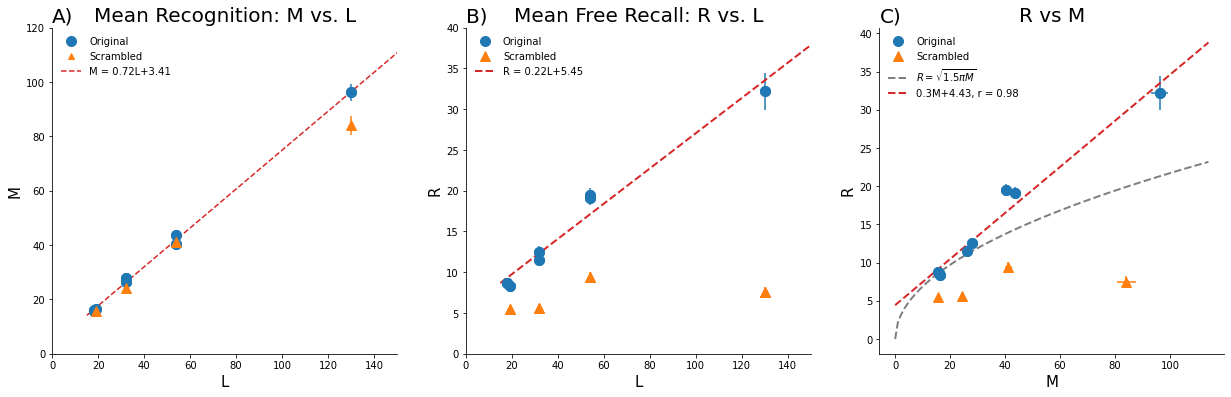

In [95]:

M_min = int(min(mt))
L_max= 2*int(max(lt))

ll = np.array([x for x in range(M_min,L_max)])




M_min = 0*int(min(mt))
M_max= int(1.2*max(mt))

m = np.array([x for x in range(M_min,M_max)])



fig, ax = plt.subplots(1,3,figsize=(21,6))#

#fig, ax = plt.subplot_mosaic([['a)', 'b)','c)']],
 #                             layout='constrained',figsize = (15,5))


ax[0].plot(lt, mt, 'o',markersize = 10,label='Original',color='tab:blue')
ax[0].errorbar(lt, mt, yerr=mt_error,fmt='o',markersize = 10,color = 'tab:blue')


ax[0].plot(lt_sc, mt_sc, '^',label='Scrambled',color='tab:orange')
ax[0].errorbar(lt_sc, mt_sc, yerr = mt_error_sc,fmt='^',markersize = 10,color = 'tab:orange')

#ax[0].plot(ll,(aM)*ll,'--',color = 'tab:red',label='M = '+str(np.round(aM[0],2))+'L, r = ' + str(np.round(r_m,3)))
ax[0].plot(ll,(ml_regress.slope.item())*ll+ml_regress.intercept.item(),'--',color = 'tab:red',label='M = '+str(ml_slope)+'L+'+str(ml_intercept))




ax[0].set_xlim([0, 150])
ax[0].set_ylim([0, 120])
ax[0].legend( frameon=False )
ax[0].set_title('Mean Recognition: M vs. L',fontsize=20)
ax[0].set_title('A)',  loc='left', fontsize=20)
ax[0].set_ylabel('M',fontsize = 15)
ax[0].set_xlabel('L',fontsize = 15)




ax[1].plot(lt, rt, 'o',markersize = 10,label='Original',color='tab:blue')
ax[1].errorbar(lt, rt, yerr=rt_error,markersize= 10,fmt='o',color='tab:blue')

ax[1].plot(lt_sc, rt_sc, '^',markersize = 10,label='Scrambled',color='tab:orange')
ax[1].errorbar(lt_sc, rt_sc, yerr = rt_error_sc,fmt='^',markersize = 10,color = 'tab:orange')
ax[1].plot(ll,(rl_regress.slope.item())*ll+rl_regress.intercept.item(),'--',color = 'tab:red',
           label='R = '+str(rl_slope)+'L+'+str(rl_intercept), linewidth = 2 )

#, r = ' + str(np.round(rl_regress.rvalue,3))

ax[1].set_xlim([0, 150])
ax[1].set_ylim([0, 40])
ax[1].legend(frameon=False)
ax[1].set_title('Mean Free Recall: R vs. L',fontsize=20)
ax[1].set_title('B)',  loc='left', fontsize=20)
ax[1].set_ylabel('R',fontsize=15)
ax[1].set_xlabel('L',fontsize=15)





ax[2].plot(mt, rt, 'o',markersize = 10, color ='tab:blue', label = 'Original')  #,label='R vs. M'
ax[2].errorbar(mt,rt,xerr = mt_error,yerr = rt_error,fmt = 'o',markersize = 10,color= 'tab:blue') #fmt='o',markersize = 4,alpha = 1.,

ax[2].plot(mt_sc, rt_sc, '^',markersize = 10, color = 'tab:orange',label = 'Scrambled')  #,label='R vs. M'

#ax[2].scatter(mt_sc, rt_sc, s=30,alpha=1, edgecolors="k",color = 'orange',label = 'Scrambled')  #,label='R vs. M'
ax[2].errorbar(mt_sc, rt_sc, xerr = mt_error_sc,yerr = rt_error_sc,fmt = '^',color = 'tab:orange')  #,label='R vs. M'


ax[2].plot(m,np.sqrt(3*np.pi/2)*np.sqrt(m),'--',color = 'tab:gray',label='$R = \sqrt{1.5 \pi M}$', linewidth = 2 )
#ax[2].plot(m,0.4096085405487828*m + 1.7540804817166027,'--',label = 'R = M',color = 'tab:red')
ax[2].plot(m,rm_slope*m +rm_intercept,'--',color = 'tab:red',
           label = str(np.round(rm_slope,2))+'M+'+str(np.round(rm_intercept,2)) + ', r = '+str(np.round(rm_rvalue,2)) ,
               linewidth = 2    )

#ax[2].plot(m,0.29*m +4.838,'-',color = 'tab:red',label = str(np.round(rm_slope,2))+'M+'+str(np.round(rm_intercept,2)))



#ax[2].set_xlim([0, 120])
#ax[2].set_ylim([0, 40])
ax[2].legend(frameon=False)
ax[2].set_title('R vs M',fontsize = 20)
ax[2].set_title('C)',  loc='left', fontsize=20)
ax[2].set_ylabel('R',fontsize = 15)
ax[2].set_xlabel('M',fontsize = 15)

for k in range(3):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)


plt.savefig('figs/scaling-plots.svg', bbox_inches='tight')

plt.show()


# Temporal order of recall (Figure 3)

In [71]:
#This extracts the data to be plotted below

order_list = []
max_len = []
story_name = []
for f in files_in_folder('compiled_data', '.pkl'):
    fn = 'data/compiled_data/' + f
    dataset = pd.read_pickle(fn)
    
    _r = dataset['recall_scores_ordered'].values
    order_list += [_r]
    max_len +=[len(dataset['segmentation'].split('\n'))]
    story_name +=[f]
#This is the random list data

fn = 'data/words/rec_pos_words_128.pkl'
word_data_2 = pd.read_pickle(fn)
word_recall = word_data_2['rec_pos']

order_list +=[np.array(word_recall,dtype = object)]
story_name +=['random list']
max_len +=[128]

In [74]:
fn = 'data/compiled_data/hester_v2-church-scrambled.pkl'
dataset_scram = pd.read_pickle(fn)
scramble_map = np.array(dataset_scram['scramble_map'])
clause_map = scramble_map+1
#hester-ordered_list
#hester-scrambled data is 

seq_list = order_list[8]
serial_seq_list = []
for i in range(len(seq_list)):
    seq = seq_list[i]
    serial_seq = []
    for _s in seq:
        serial_seq +=[np.argwhere(clause_map ==_s).item() + 1]
    
    serial_seq_list +=[serial_seq]

serial_seq_list = np.array(serial_seq_list,dtype = object)

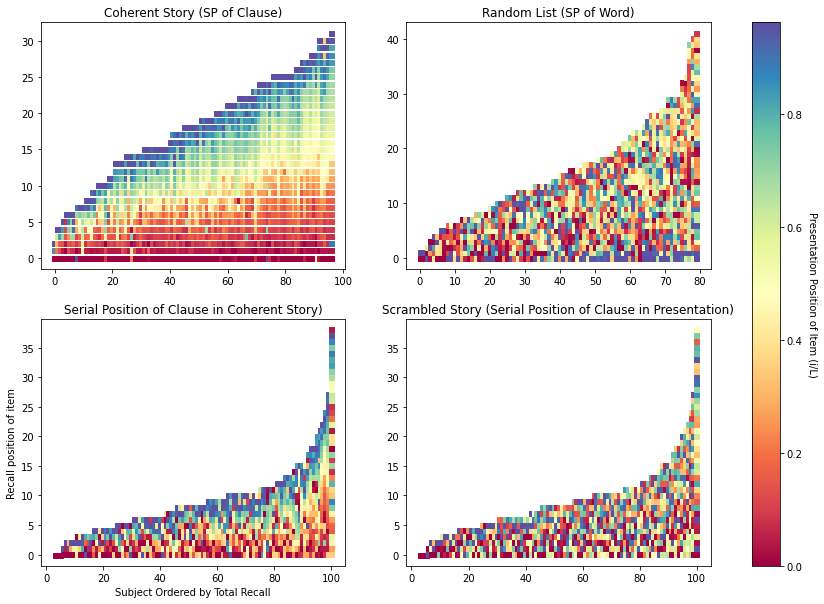

In [75]:
_id = 2;  #Coherent Storyselect Id of story above
_id2 = 15  #random list

_id3 = 8

marker_size = 25
num_legend_elements = 5;
num_legend_elements2 = 6;

dimX = 15
dimY = 10

###########################
###########################

_r = order_list[_id]

r_tot = []
for rec in _r:
    r_tot +=[len(rec)]
idx_r_tot = np.argsort(r_tot)[:-3]

_r = _r[idx_r_tot]

###########################
###########################

_r2 = order_list[_id2]

r_tot2 = []
for rec in _r2:
    r_tot2 +=[len(rec)]

idx_r_tot2 = np.argsort(r_tot2)[:]

_r2 = _r2[idx_r_tot2]


###########################
###########################

_r3 = order_list[_id3]

r_tot3 = []
for rec in _r3:
    r_tot3 +=[len(rec)]

idx_r_tot3 = np.argsort(r_tot3)[:]

_r3 = _r3[idx_r_tot3]

###########################
###########################

_r4 = serial_seq_list

r_tot4 = []
for rec in _r4:
    r_tot4 +=[len(rec)]

idx_r_tot4 = np.argsort(r_tot4)[:]

_r4 = _r4[idx_r_tot4]


fig, ax = plt.subplots(2,2,figsize = (dimX,dimY))



for k in range(len(_r)):
    x = [k for i in range(len(_r[k]))]
    y=[i for i in range(len(_r[k]))]
    ys = (np.array(_r[k])-1)/(max_len[_id]-1)
    scatter1 = ax[0,0].scatter(x,y,c = ys,s = marker_size,marker = 's',cmap = 'Spectral')   

#legend1 = ax[0,0].legend(*scatter1.legend_elements(num = num_legend_elements),title="Serial Position of Clause (i/L)")
#ax[0,0].add_artist(legend1)

for k in range(len(_r2)):
    x = [k for i in range(len(_r2[k]))]
    y=[i for i in range(len(_r2[k]))]
    ys = (np.array(_r2[k])-1)/(max_len[_id2]-1)
    scatter2 = ax[0,1].scatter(x,y,c = ys,s = marker_size,marker = 's',cmap = 'Spectral')   

#legend2 = ax[0,1].legend(*scatter2.legend_elements(num = num_legend_elements),title="Serial Position of Word in Presentation (i/L)")
#ax[0,1].add_artist(legend2)


for k in range(len(_r3)):
    x = [k for i in range(len(_r3[k]))]
    y=[i for i in range(len(_r3[k]))]
    ys = (np.array(_r3[k])-1)/(max_len[_id3]-1)
    scatter3 = ax[1,0].scatter(x,y,c = ys,s = marker_size,marker = 's',cmap = 'Spectral')   

#legend3 = ax[1,0].legend(*scatter3.legend_elements(num = num_legend_elements),title="Serial Position in Original (i/L)")
#ax[1,0].add_artist(legend3)


for k in range(len(_r4)):
    x = [k for i in range(len(_r4[k]))]
    y=[i for i in range(len(_r4[k]))]
    ys = (np.array(_r4[k])-1)/(max_len[_id3]-1)
    scatter4 = ax[1,1].scatter(x,y,c = ys,s = marker_size,marker = 's',cmap = 'Spectral')   

#cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#fig.colorbar(scatter1, cax = cax, ticks=[range(0, 100, 10)],orientation='vertical')    
    
#legend4 = ax[1,1].legend(*scatter4.legend_elements(num = num_legend_elements),title="Serial Position in Presention (i/L)")
#ax[1,1].add_artist(legend4)



ax[0,0].set_title('Coherent Story (SP of Clause)')

ax[0,1].set_title('Random List (SP of Word)')


ax[1,0].set_title('Serial Position of Clause in Coherent Story)')
ax[1,1].set_title('Scrambled Story (Serial Position of Clause in Presentation)')


ax[1,0].set_xlabel('Subject Ordered by Total Recall')
ax[1,0].set_ylabel('Recall position of item')
#plt.ylabel('Recall Sequence')

cbar = fig.colorbar(scatter4, ax=ax,orientation = 'vertical')

cbar.set_label('Presentation Position of Item (i/L)', rotation=270,labelpad = 15)


#plt.xlabel('subject ordered by total recall')
#plt.ylabel('Recall position')
plt.savefig('recall_sequence_narrative_vs_list.png')
plt.show()

schissel_v1-pool.pkl 18
triplett_v1-rookie.pkl 32
hester_v2-church.pkl 54
triplett_v2-catlady.pkl 32
panic.pkl 56
schissel_v2-lake.pkl 18
boyscout.pkl 19
ghosts.pkl 44
biker.pkl 42
hester_v1-park.pkl 54
stein.pkl 130


<Figure size 720x216 with 0 Axes>

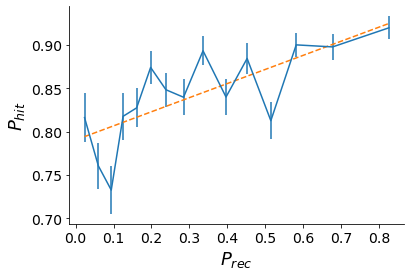

In [98]:
th= 0.15
n_th= 5
attracting_force= []
hit_stats= np.empty((0, 2), dtype= int)
p_recs= np.empty((0,))
for fname in os.listdir('data/compiled_data'):
    if "scrambled" in fname:
        continue
    print(fname, end=" ")
    data= pd.read_pickle(os.path.join('data/compiled_data',fname) )
    ordered_recall= data['recall_scores_ordered']
    segm= data["segmentation"].split("\n")


    n_clauses= len(segm)
    
    print(n_clauses)
    hit_stat= np.zeros( (n_clauses, 2), dtype= int)
    for recs in data['recognition']:
        for r in recs:
            if r['value'] in ['hit', 'miss']:
                hit_stat[r['id'], (r['value']=='hit')+0] += 1
    hit_stats= np.vstack( (hit_stats, hit_stat) )

    p_rec= np.zeros( (n_clauses+1), dtype= np.int64 )
    for s in ordered_recall:
        for s1 in s :
            p_rec[ s1 ] += 1
    
    p_rec= p_rec/len(ordered_recall)
    #print(  p_rec.shape, hit_stat.shape )
    p_recs= np.hstack( (p_recs, p_rec[1:]) )
    ii= np.argsort(p_rec)[::-1]
    #for k in sorted(ii[:len(ii)//4]):
    #for k in sorted(np.where(p_rec>0.5)[0]):
    #    print( f"Prec={p_rec[k]:.3f},  {segm[k-1]}" )

ii = hit_stats.sum(axis=1)>0
p_recs_good= p_recs[ii]
hit_stats_good= hit_stats[ii,:]

n_bins= 15
bin_boundaries= np.percentile( p_recs_good, np.linspace(0,100,n_bins+1) )
bin_boundaries[-1]= 1.0
bin_idx= np.digitize(p_recs_good, bin_boundaries)

bin_stats= np.zeros( (n_bins, 4) )
for k in range(n_bins):
    ii = (bin_idx==k+1)
    bin_stats[k,0]= (bin_boundaries[k]+bin_boundaries[k+1])/2
    bin_stats[k,1]= np.sum( hit_stats_good[ii, 0] )
    bin_stats[k,2]= np.sum( hit_stats_good[ii, 1] )
    bin_stats[k,3]= np.mean( p_recs_good[ii] )
p_hit_bin= bin_stats[:,2]/(bin_stats[:,1]+bin_stats[:,2])
p_hit_err= np.sqrt( p_hit_bin*(1-p_hit_bin)/(bin_stats[:,1]+bin_stats[:,2]) )
m,b = np.polyfit( bin_stats[:,3], p_hit_bin, 1)
plt.figure( figsize=(10,3) )
fig, ax = plt.subplots()
plt.errorbar(bin_stats[:,3], p_hit_bin, yerr= p_hit_err, label= "data")
plt.plot(bin_stats[:,3], m*bin_stats[:,3]+b, '--', label= f"y={m:.3f}x+{b:.3f}")
plt.xlabel("$P_{rec}$", fontsize=18)
plt.ylabel("$P_{hit}$", fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim(0,1)
plt.savefig('figs/p_hit_vs_p_rec.svg')
    

In [115]:
def get_Prec( ordered_recall ):
    n_clauses= max( max( s ) for s in ordered_recall if s )
    n=n_clauses+1
    pRec= np.zeros( (n), dtype= np.int64 )
    for s in ordered_recall:
        for s1 in s :
            pRec[ s1 ] += 1
    return pRec

best_recalls= {'schissel_v1-pool.pkl': {'n': 5, 'fixed': True},
 'triplett_v1-rookie.pkl': {'n': 7, 'fixed': True},
 'hester_v2-church.pkl': {'n': 9, 'fixed': True},
 'triplett_v2-catlady.pkl': {'n': 9, 'fixed': True},
 'panic.pkl': {'n': 9, 'fixed': True},
 'boyscout-scrambled.pkl': {'n': 11, 'fixed': True},
 'schissel_v2-lake.pkl': {'n': 5, 'fixed': True},
 'triplett_v1-rookie-scrambled.pkl': {'n': 11, 'fixed': True},
 'hester_v2-church-scrambled.pkl': {'n': 5, 'fixed': True},
 'boyscout.pkl': {'n': 9, 'fixed': True},
 'ghosts.pkl': {'n': 15, 'fixed': True},
 'biker.pkl': {'n': 7, 'fixed': True},
 'stein-scrambled.pkl': {'n': 5, 'fixed': True},
 'hester_v1-park.pkl': {'n': 8, 'fixed': True},
 'stein.pkl': {'n': 30, 'fixed': True}}

th= 0.15
n_th= 5
attracting_force= []
for fname in best_recalls:
    #if best_recalls[fname]["fixed"]:
    #    continue
    print(fname)
    data= pd.read_pickle(os.path.join('data/compiled_data',fname) )
    ordered_recall= data['recall_scores_ordered']
    segm= data["segmentation"].split("\n")
   
    n_clauses= max( max( s ) for s in data["recall scores"] if s )
    
    p_rec= get_Prec(ordered_recall)/len(ordered_recall)
    ii= np.argsort(p_rec)[::-1]
    #print("\\begin{plabel}")
    for k in sorted(ii[:best_recalls[fname]["n"]]):
    #for k in sorted(np.where(p_rec>0.5)[0]):
        print( f"{k:3d}, {p_rec[k]:.3f},  {segm[k-1]}" )
        #print( f"\\item[ {p_rec[k]:.3f}]  {segm[k-1]}" )
    #print("\\end{plabel}")
    print(" ------------------ ")

    #print("\\begin{enumerate}")
    for k, cl in enumerate(segm):
        cl_ = cl.split('.')
        print(f"{k+1}, {cl_[1]}")
        #print(f"\\item {cl_[1]}")
    #print("\\end{enumerate}")
    print("\n  =======------------------======= \n")
    #break

    

schissel_v1-pool.pkl
  1, 0.857,  1. My best friend pushed me into the pool.
  2, 0.893,  2. This happened during my cousin's wedding reception,
  5, 0.893,  5. she spotted a bee hovering near my face,
 16, 0.661,  16. And... my beautiful dress was ruined,
 18, 0.857,  18. and my cousin just says, "Just about a few inches more," she says, "and you'd have landed on the cake."
 ------------------ 
1,  My best friend pushed me into the pool
2,  This happened during my cousin's wedding reception,
3,  where everyone was dressed to impress
4,  And the reason it happened,
5,  she spotted a bee hovering near my face,
6,  - this was at a fancy hotel garden -
7,  and she tried to save me from being stung
8,  And my aunt had just handed me a glass of champagne,
9,  and I warned her to be careful
10,  'Course friends, y'know, they don't always think things through
11,  So that's when she gave me a little shove,
12,  and I tumbled into the water
13,  When I resurfaced, gasping for air,
14,  she jus